In [2]:
# Project for Data Science. Group . Igor Ivanov

# Imports
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [3]:
TRAIN_DATASET_PATH = 'Project/DataScience/train.csv'
TEST_DATASET_PATH = 'Project/DataScience/test.csv'

# Load train dataset
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [5]:
# Load test dataset
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
test_df.head()

train_df.shape, test_df.shape

((10000, 19), (5000, 18))

In [7]:
# Check dataset fields types
train_df.dtypes

train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [8]:
# Process gaps
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [12]:
# Gap: LifeSquare calculation
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = \
    test_df['Square'] - test_df['KitchenSquare']

In [9]:
# Gap: HealthCare_1. Change to a median
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)
test_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)

HouseFloor      -0.14
Floor           -0.14
Ecology_1       -0.04
Square          -0.04
LifeSquare      -0.03
HouseYear       -0.01
KitchenSquare    0.01
Rooms            0.04
Social_2         0.05
Shops_1          0.06
Social_1         0.08
Social_3         0.13
Price            0.14
Helthcare_2      0.20
Healthcare_1     1.00
Name: Healthcare_1, dtype: float64

In [13]:
# Anomalies processing

# Anomalies: Rooms
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
6.00        1
19.00       1
Name: Rooms, dtype: int64

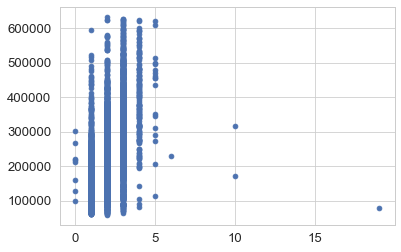

In [14]:
plt.scatter(train_df['Rooms'], train_df['Price']);

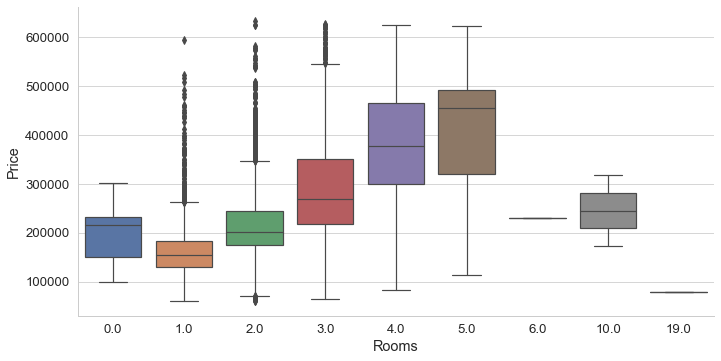

In [15]:
sns.catplot('Rooms', 'Price', kind="box", data=train_df, aspect=2/1);

In [16]:
test_df['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

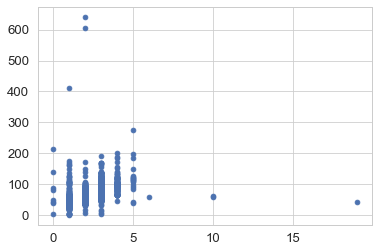

In [17]:
plt.scatter(train_df['Rooms'], train_df['Square']);

In [18]:
train_df['Rooms'].mode()[0]

2.0

In [19]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]

In [21]:
# Anomalies: Square, LifeSquare, KitchenSquare

train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,41.80,6.27
std,21.06,77.82,28.56
min,1.14,0.37,0.00
25%,41.77,25.49,1.00
50%,52.51,37.04,6.00
75%,65.90,49.82,9.00
max,641.07,"7,480.59","2,014.00"


In [22]:
train_df['KitchenSquare'].value_counts()

1.00     2460
8.00     1306
5.00     1169
10.00    1075
6.00     1038
         ... 
36.00       1
53.00       1
96.00       1
62.00       1
75.00       1
Name: KitchenSquare, Length: 58, dtype: int64

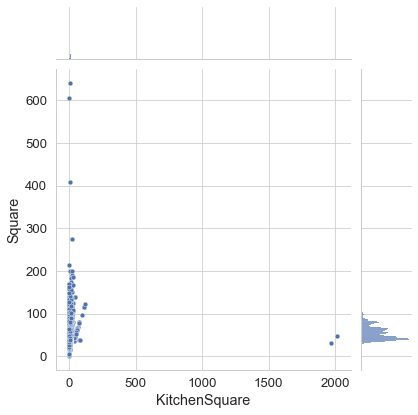

In [23]:
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind='scatter', height=6);

In [24]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,B,B,2,629,1,NaN,0,0,A,"108,337.48"
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,B,B,21,5731,0,NaN,1,0,B,"160,488.03"
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,B,B,4,915,0,NaN,0,0,B,"99,079.96"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,B,B,30,5285,0,645.00,6,6,B,"105,539.56"


In [25]:
train_df['KitchenSquare'].median()

6.0

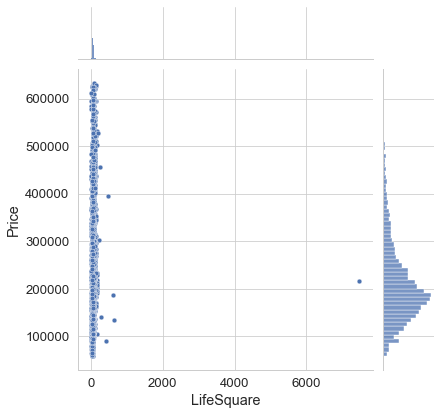

In [27]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']),
             'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[(test_df['KitchenSquare'] > 150) | \
            (test_df['KitchenSquare'] > test_df['Square']),
            'KitchenSquare'] = train_df['KitchenSquare'].median()

sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='scatter', height=6);

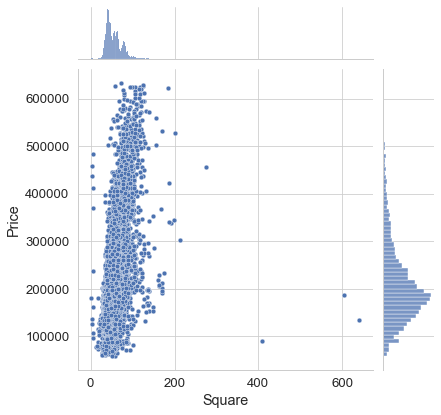

In [28]:
train_df.loc[(train_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()
test_df.loc[(test_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()

sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6);

In [29]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,B,B,43,8429,3,NaN,3,9,B,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,B,B,4,915,0,NaN,0,0,B,"107,604.27"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"137,597.60"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,B,B,9,1892,0,NaN,0,1,B,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,B,B,16,3433,4,"2,643.00",4,5,B,"369,472.40"
28,9,2.00,604.71,37.04,1.00,17,18.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B,"187,717.24"
2307,102,1.00,409.43,37.04,10.00,4,4.00,2016,0.24,B,B,26,3889,6,705.00,3,6,B,"90,470.43"
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,NaN,0,0,B,"126,596.94"
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,B,B,9,1892,0,NaN,0,1,B,"161,379.07"


In [30]:
train_df['Square'].median()

52.51330992401352

In [31]:
(train_df['Square'] / train_df['Rooms']).median()

30.82149803272398

In [32]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])

830

In [33]:
train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
8054,23,1.00,42.53,43.97,1.00,3,9.00,2014,0.03,B,B,0,168,0,NaN,0,0,B,"95,338.20"
10521,38,3.00,104.21,106.34,0.00,20,0.00,2017,0.06,B,B,15,2787,2,520.00,0,7,B,"435,462.05"
7596,23,1.00,47.08,46.81,12.00,3,9.00,1977,0.01,B,B,2,475,0,NaN,0,0,B,"96,029.17"
2301,1,2.00,61.40,65.22,0.00,17,22.00,2016,0.01,B,B,1,264,0,NaN,0,1,B,"199,215.45"


In [34]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.22,40.86,5.86
std,19.06,20.57,5.07
min,13.78,0.37,0.00
25%,41.79,25.49,1.00
50%,52.51,37.04,6.00
75%,65.89,49.77,9.00
max,275.65,263.54,123.00


In [36]:
# Anomalies:  HouseFloor, Floor
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [37]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

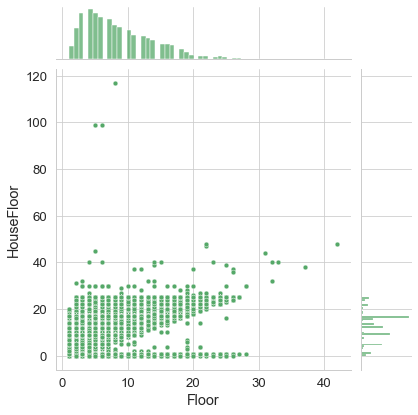

In [38]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=6, color='g');

In [39]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [40]:
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [41]:
# Anomalies: HouseYear
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
8892         2020
3445         2020
6731         2020
           ...   
7920         1916
6751         1914
14556        1912
2085         1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [42]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011

In [ ]:
# Rare categories processing